In [1]:
import os, sys, subprocess
conda_prefix = os.environ.get("CONDA_PREFIX", sys.prefix)  # raíz del env actual
os.environ["JAVA_HOME"] = conda_prefix
os.environ["PATH"] = f"{conda_prefix}/bin:" + os.environ["PATH"]

# Verifica que Java responde
print("JAVA_HOME:", os.environ["JAVA_HOME"])
print(subprocess.run(["java", "-version"], capture_output=True, text=True).stderr)

JAVA_HOME: /opt/conda
openjdk version "11.0.27-internal" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27-internal+0-adhoc..src)
OpenJDK 64-Bit Server VM (build 11.0.27-internal+0-adhoc..src, mixed mode)



In [2]:
import os
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

In [3]:
base_dir = os.path.expanduser("~")  # carpeta local del cuaderno

In [4]:
builder = (
    SparkSession.builder
    .appName("spark-local-delta")
    .config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-de6a493e-bb25-4f1c-a136-c61651a0fdb3;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.2.0 in central
	found io.delta#delta-storage;3.2.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 369ms :: artifacts dl 11ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.2.0 from central in [default]
	io.delta#delta-storage;3.2.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default  

In [5]:
# Lee el CSV local que hayas subido al Jupyter (sin S3)
csv_path   = f"file://{base_dir}/STAR.csv"
delta_path = f"file://{base_dir}/delta/STAR"
parquet_path = f"file://{base_dir}/parquet/STAR"

In [6]:
df = (spark.read.format("csv").option("header", True).option("inferSchema", True).load(csv_path))

In [7]:
(df.write.format("delta").mode("overwrite").save(delta_path))

25/11/18 18:39:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

In [8]:
spark.read.format("delta").load(delta_path).show(5)

+----+------+---------+-------+------------+-----+------------+------------+-----+-----+-----+-----+-----+-----+-----+-----+--------+------+--------+--------+----------+--------+--------+--------+--------+--------+--------+--------+---------+---------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+-------+-------+-------+---------+---------+---------+---------+
|  c0|gender|ethnicity|  birth|       stark|star1|       star2|       star3|readk|read1|read2|read3|mathk|math1|math2|math3|  lunchk|lunch1|  lunch2|  lunch3|   schoolk| school1| school2| school3| degreek| degree1| degree2| degree3|  ladderk|  ladder1|   ladder2|   ladder3|experiencek|experience1|experience2|experience3|tethnicityk|tethnicity1|tethnicity2|tethnicity3|systemk|system1|system2|system3|schoolidk|schoolid1|schoolid2|schoolid3|
+----+------+---------+-------+------------+-----+------------+------------+-----+-----+-----+-----+-----+-----+--

In [9]:
from pyspark.sql.types import DoubleType
df = df.withColumn("readk",df["readk"].cast(DoubleType()))
df = df.withColumn("read1",df["read1"].cast(DoubleType()))
df = df.withColumn("read2",df["read2"].cast(DoubleType()))
df = df.withColumn("read3",df["read3"].cast(DoubleType()))
df = df.withColumn("mathk",df["mathk"].cast(DoubleType()))
df = df.withColumn("math1",df["math1"].cast(DoubleType()))
df = df.withColumn("math2",df["math2"].cast(DoubleType()))
df = df.withColumn("math3",df["math3"].cast(DoubleType()))
df = df.withColumn("experiencek",df["experiencek"].cast(DoubleType()))
df = df.withColumn("experience1",df["experience1"].cast(DoubleType()))
df = df.withColumn("experience2",df["experience2"].cast(DoubleType()))
df = df.withColumn("experience3",df["experience3"].cast(DoubleType()))

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer,OneHotEncoder

colGen = ['gender','ethnicity','birth']
colGenI = ['genderI','ethnicityI','birthI']
colGenE = ['genderE','ethnicityE','birthE']

colk = ['stark','lunchk','schoolk','degreek','ladderk','tethnicityk','systemk','schoolidk']
colkI = ['starkI','lunchkI','schoolkI','degreekI', 'ladderkI','tethnicitykI','systemkI','schoolidkI']
colkE =['starkE','lunchkE','schoolkE','degreekE', 'ladderkE','tethnicitykE','systemkE','schoolidkE']

col1 =['star1','lunch1','school1','degree1', 'ladder1','tethnicity1','system1','schoolid1']
col1I = ['star1I','lunch1I','school1I','degree1I', 'ladder1I','tethnicity1I','system1I','schoolid1I']
col1E =['star1E','lunch1E','school1E','degree1E', 'ladder1E','tethnicity1E','system1E','schoolid1E']

col2 =['star2','lunch2','school2','degree2', 'ladder2','tethnicity2','system2','schoolid2']
col2I = ['star2I','lunch2I','school2I','degree2I', 'ladder2I','tethnicity2I','system2I','schoolid2I']
col2E =['star2E','lunch2E','school2E','degree2E', 'ladder2E','tethnicity2E','system2E','schoolid2E']

col3 =['star3','lunch3','school3','degree3', 'ladder3','tethnicity3','system3','schoolid3']
col3I = ['star3I','lunch3I','school3I','degree3I', 'ladder3I','tethnicity3I','system3I','schoolid3I']
col3E =['star3E','lunch3E','school3E','degree3E', 'ladder3E','tethnicity3E','system3E','schoolid3E']

input_cols = colGen + colk + col1 + col2 + col3
index_cols = colGenI + colkI + col1I + col2I + col3I
encoded_cols = colGenE + colkE + col1E + col2E + col3E

indexer = StringIndexer(inputCols=input_cols, outputCols=index_cols)
encoder = OneHotEncoder(inputCols=index_cols, outputCols=encoded_cols)
pipeline = Pipeline(stages=[indexer, encoder])
df = pipeline.fit(df).transform(df)

In [11]:
df_pandas = df.toPandas().dropna()

<Axes: title={'center': 'read3'}, xlabel='star3'>

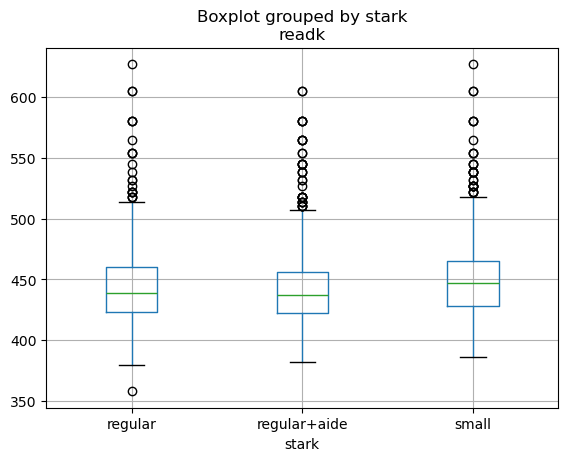

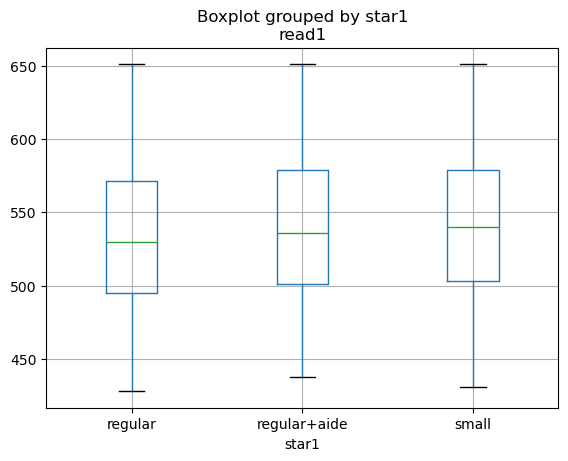

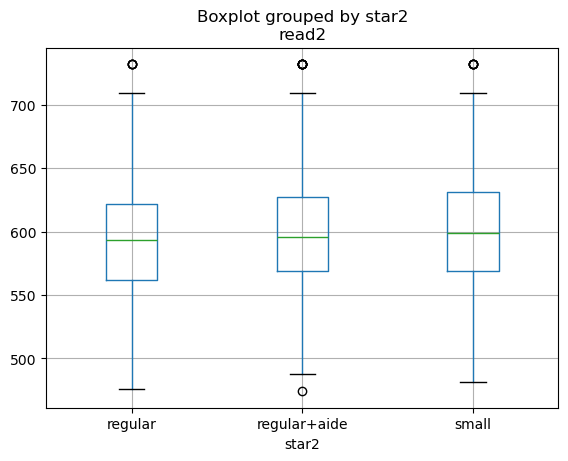

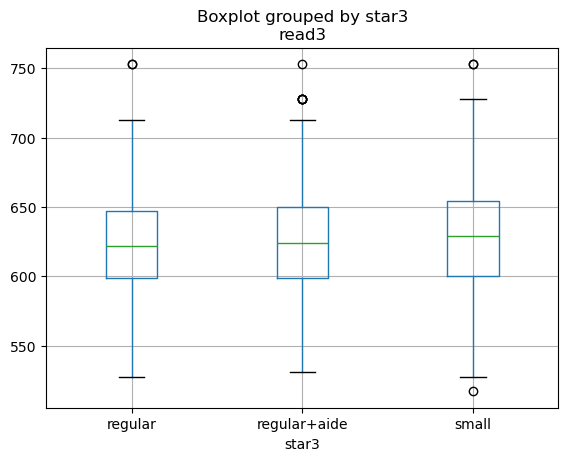

In [12]:
df_pandas.boxplot(by='stark', column=['readk'])
df_pandas.boxplot(by='star1', column=['read1'])
df_pandas.boxplot(by='star2', column=['read2'])
df_pandas.boxplot(by='star3', column=['read3'])

<Axes: title={'center': 'math3'}, xlabel='star3'>

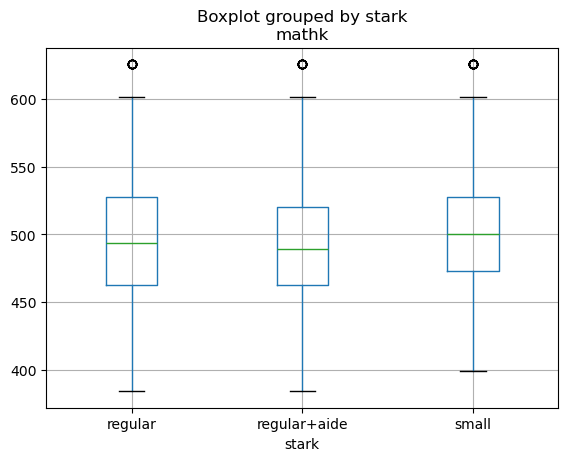

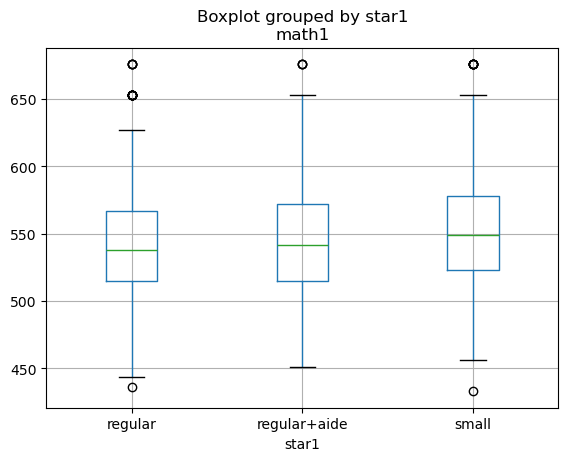

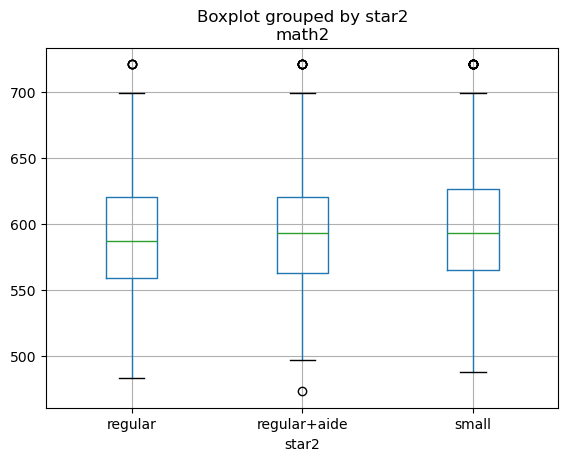

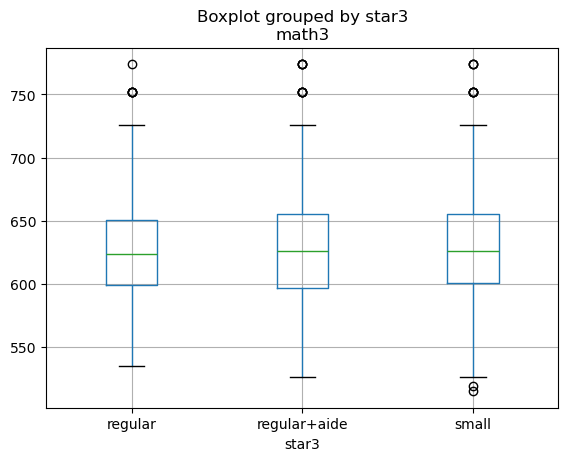

In [13]:
df_pandas.boxplot(by='stark', column=['mathk'])
df_pandas.boxplot(by='star1', column=['math1'])
df_pandas.boxplot(by='star2', column=['math2'])
df_pandas.boxplot(by='star3', column=['math3'])

In [14]:
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

colinputk = ['genderI', 'ethnicityI', 'birthI', 'starkI', 'lunchkI', 'schoolkI', 'degreekI', 'ladderkI', 'tethnicitykI']

train_df, test_df = df.randomSplit([0.75, 0.25], seed=42)

imputer = Imputer(
    inputCols=["readk"],
    outputCols=["myreadk_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="myreadk_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myreadk_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myreadk_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

25/11/18 18:40:13 WARN Instrumentation: [806fb5ab] regParam is zero, which might cause numerical instability and overfitting.
[Stage 34:>                                                         (0 + 1) / 1]

MSE en test: 503.37616093626974
R2 en test: 0.061684663515676474


In [15]:
print("Primero")

imputer = Imputer(
    inputCols=["read1"],
    outputCols=["myread1_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="myread1_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myread1_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myread1_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

Primero


25/11/18 18:40:27 WARN Instrumentation: [6fba69db] regParam is zero, which might cause numerical instability and overfitting.
[Stage 43:>                                                         (0 + 1) / 1]

MSE en test: 1643.6721610395414
R2 en test: 0.05805628012320907


In [16]:
print("Segundo")

imputer = Imputer(
    inputCols=["read2"],
    outputCols=["myread2_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="myread2_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myread2_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myread2_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

Segundo


25/11/18 18:40:38 WARN Instrumentation: [9aa3c39e] regParam is zero, which might cause numerical instability and overfitting.
[Stage 52:>                                                         (0 + 1) / 1]

MSE en test: 981.1480167288838
R2 en test: 0.07770932037671852


In [17]:
print("Tercero")

imputer = Imputer(
    inputCols=["read3"],
    outputCols=["myread3_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="myread3_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myread3_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myread3_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

Tercero


25/11/18 18:40:48 WARN Instrumentation: [7b3cb95e] regParam is zero, which might cause numerical instability and overfitting.
[Stage 61:>                                                         (0 + 1) / 1]

MSE en test: 695.1300473330668
R2 en test: 0.07503089443222177


In [18]:
print("Jardin de infancia")

imputer = Imputer(
    inputCols=["mathk"],
    outputCols=["mymathk_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="mymathk_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymathk_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymathk_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

Jardin de infancia


25/11/18 18:40:58 WARN Instrumentation: [d1b52560] regParam is zero, which might cause numerical instability and overfitting.
[Stage 70:>                                                         (0 + 1) / 1]

MSE en test: 1112.549184862266
R2 en test: 0.050890607678668154


In [19]:
print("Primero")

imputer = Imputer(
    inputCols=["math1"],
    outputCols=["mymath1_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="mymath1_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymath1_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymath1_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

Primero


25/11/18 18:41:08 WARN Instrumentation: [03c8b13a] regParam is zero, which might cause numerical instability and overfitting.
[Stage 79:>                                                         (0 + 1) / 1]

MSE en test: 1010.0030456094617
R2 en test: 0.06098024859693418


In [20]:
print("Segundo")

imputer = Imputer(
    inputCols=["math2"],
    outputCols=["mymath2_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="mymath2_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymath2_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymath2_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

Segundo


25/11/18 18:41:18 WARN Instrumentation: [08c24fb4] regParam is zero, which might cause numerical instability and overfitting.
[Stage 88:>                                                         (0 + 1) / 1]

MSE en test: 912.4900329733226
R2 en test: 0.06159820506123026


In [21]:
print("Tercero")

imputer = Imputer(
    inputCols=["math3"],
    outputCols=["mymath3_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

lr = LinearRegression(
    featuresCol="myfeatures",
    labelCol="mymath3_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, lr])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymath3_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymath3_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

Tercero


25/11/18 18:41:27 WARN Instrumentation: [456b4962] regParam is zero, which might cause numerical instability and overfitting.
[Stage 97:>                                                         (0 + 1) / 1]

MSE en test: 775.3777634429293
R2 en test: 0.05584304557410169


In [22]:
# Repetimos con RandomForest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

colinputk = ['genderI', 'ethnicityI', 'birthI', 'starkI', 'lunchkI', 'schoolkI', 'degreekI', 'ladderkI', 'tethnicitykI']

train_df, test_df = df.randomSplit([0.75, 0.25], seed=42)

imputer = Imputer(
    inputCols=["readk"],
    outputCols=["myreadk_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="myreadk_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myreadk_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myreadk_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

In [ ]:
print("Primero")

imputer = Imputer(
    inputCols=["read1"],
    outputCols=["myread1_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="myread1_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myread1_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myread1_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

In [ ]:
print("Segundo")

imputer = Imputer(
    inputCols=["read2"],
    outputCols=["myread2_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="myread2_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myread2_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myread2_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

In [ ]:
print("Tercero")

imputer = Imputer(
    inputCols=["read3"],
    outputCols=["myread3_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="myread3_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="myread3_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="myread3_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

In [ ]:
print("Jardin de infancia")

imputer = Imputer(
    inputCols=["mathk"],
    outputCols=["mymathk_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="mymathk_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymathk_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymathk_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

In [ ]:
print("Primero")

imputer = Imputer(
    inputCols=["math1"],
    outputCols=["mymath1_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="mymath1_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymath1_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymath1_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

In [ ]:
print("Segundo")

imputer = Imputer(
    inputCols=["math2"],
    outputCols=["mymath2_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="mymath2_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymath2_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymath2_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)

In [ ]:
print("Tercero")

imputer = Imputer(
    inputCols=["math3"],
    outputCols=["mymath3_imputado"],
    strategy="mean"
)

assembler = VectorAssembler(
    inputCols=colinputk,
    outputCol="myfeatures"
)

rf = RandomForestRegressor(
    featuresCol="myfeatures",
    labelCol="mymath3_imputado"
)

pipeline = Pipeline(stages=[imputer, assembler, rf])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator_mse = RegressionEvaluator(
    labelCol="mymath3_imputado",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="mymath3_imputado",
    predictionCol="prediction",
    metricName="r2"
)

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MSE en test:", mse)
print("R2 en test:", r2)